In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import json

from keras.models import Sequential, load_model
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


# Summary
I'm fitting the keras' embedding layer for 10 epochs within the possibly simplest imaginable setup, namely with glabal averaging and softmax on top. This fairly inexpensive but broad examination serves to produce reasonable starting embeddings for more complicated net architectures and to compare various loss functions. The latter are a somewhat subtle matter due to the class imbalance of our dataset.
* Results land in the directory *my_embeddings*.
* Weights are stores as *weights_blabla.p* and they may be directly depickled into the *weights* argument of the Embedding layer.
* There are nice plots below. 

---

### Load the data in
The test data is not used

In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [3]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))

---

### Some custom definitions
* metrics
* loss functions
* choice of learning parameters and settings

In [23]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(y_true * y_pred, axis=0)
        actual_ones = K.sum(y_true, axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(y_true * y_pred, axis=0)
        positives = K.sum(y_pred, axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) ) 
    
    return 1-macroF1


# weighted categorical crossentropy
def my_crossE(y_true, y_pred):
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = class_weights * class_entropy
    return -7E-4 * K.mean(weighted_entropy)  # arbitrary coefficient to make it close to [0-1] interval


# take average of the last two, because why not
def my_loss(y_true, y_pred):
    return 0.5*(fuzzy_macroF1_flip(y_true, y_pred) + my_crossE(y_true, y_pred))

In [24]:
# some other global learning settings

epochs = 10
batch_size = 3000
#patience = 4
optimizer = 'adam' # 'rmsprop'
my_metrics = [macroPrec, macroF1, macroRecall, my_crossE, fuzzy_macroF1_flip, my_loss]

In [25]:
# auxiliary functions
    

# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(12, 5))
    
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 2, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 2, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history[metric]
        val_results = history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
#     plt.subplot(1, 3, 3)
#     lr = history.history['lr'] # learning rate
#     plt.plot(x, lr, 'k', label='Learning rate')
#     plt.title('Learning rate')  
#     plt.legend()
    

# choose callback functions to be given in model.fit(...)
def callbacks(LRfactor=0.5):
    return [ReduceLROnPlateau(factor=LRfactor, patience = patience//2),
            EarlyStopping(monitor='val_macroF1', mode='max', patience=patience)
           ]

---

### Define a wrapper class for creating the classification model with embedding, fitting, etc.
It creates an useful object using a list of intermediate layers as the main argument.
Makes it easier to consistently use the chosen metrics, loss function, class_weights, embedding etc.

In [26]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks=None, class_weight=class_weights, epochs=epochs,\
                 embedd = None, embedd_dims=[None]*3, train_weights=False):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.class_weight = class_weight
        self.epochs = epochs
        self.train_weigts = train_weights
        self.history = None
        self.test_results = None
        
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            with open(embedd, "rb") as f:
                self.embedd_weights = pickle.load(f)
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts))
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=50):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.test_results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self, X_test, y_test):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        self.test_results = self.model.evaluate(X_test, y_test)
        return self.test_results
    
    def plot(self):
        plot_history(self.history.history)
        
    def save_embedd(self, name):
        file = os.path.join("my_embeddings", f"weights_{name}.p")
        with open(file, 'wb') as f:
            pickle.dump(self.model.layers[0].get_weights(), f)
        
    def Ksave(self, name):
        file = os.path.join("my_embeddings", f"Kmodel_from_{name}.h5")
        self.model.save(file)
    
    def save_hist(self, name):
        file = os.path.join("my_embeddings", f"history_of_{name}.p")
        with open(file, 'w') as f:
            json.dump(self.history.history, f) 


In [27]:
custom_objects={'macroPrec': macroPrec,\
                'macroF1': macroF1,\
                'macroRecall': macroRecall,\
                'my_crossE': my_crossE,\
                'fuzzy_macroF1_flip': fuzzy_macroF1_flip,\
                'my_loss': my_loss
               }

---

## Training a keras-layer embedding
### (naively, not CBOW or skipgram)
* using only global-average-pooling before softmax
* training for a fixed, short number of epochs: the goal is not to train the dense classification layer but to pretrain the embedding
* mask zeros in input
* use class_weights with default keras loss functions
* do not use class_weights with fuzzy_macroF1 or my_crossE
* save weights to files
* see which loss function got the best val_macroF1 at the last epoch

### loss=*categorical_crossentropy*, class_weight

In [11]:
# dimension of the embedding space = output_dim

layers1 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model1 = BlackBox(layers=layers1, loss='categorical_crossentropy', class_weight=class_weights, metrics=my_metrics)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [12]:
model1.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 166s 333us/step - loss: 1.2598 - macroPrec: 0.0922 - macroF1: 0.0634 - macroRecall: 0.0634 - my_crossE: 0.2342 - fuzzy_macroF1_flip: 0.8382 - val_loss: 0.8159 - val_macroPrec: 0.3091 - val_macroF1: 0.1694 - val_macroRecall: 0.1721 - val_my_crossE: 0.2531 - val_fuzzy_macroF1_flip: 0.7766
Epoch 2/10
500000/500000 [==============================] - 167s 334us/step - loss: 0.6099 - macroPrec: 0.4186 - macroF1: 0.3014 - macroRecall: 0.2750 - my_crossE: 0.2439 - fuzzy_macroF1_flip: 0.7108 - val_loss: 0.4590 - val_macroPrec: 0.4619 - val_macroF1: 0.4080 - val_macroRecall: 0.3738 - val_my_crossE: 0.2344 - val_fuzzy_macroF1_flip: 0.6506
Epoch 3/10
500000/500000 [==============================] - 165s 331us/step - loss: 0.3939 - macroPrec: 0.4549 - macroF1: 0.4284 - macroRecall: 0.4077 - my_crossE: 0.2250 - fuzzy_macroF1_flip: 0.6170 - val_loss: 0.3496 - val_macroPrec: 0.4509 - val_mac

In [13]:
name = f"50dim_GlblAvg_CatCrossE_{epochs}epochs"
model1.save_embedd(name)
model1.Ksave(name)
model1.save_hist(name)

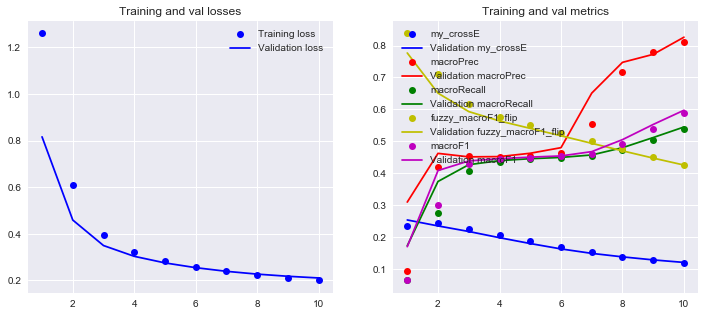

In [14]:
model1.plot()

### Comment
For all measurements the results on test and validation data were very close.
At first the macro precision, recall and F1 (per batch) rose together and plateaued around 0.4 for about four epochs. Then the precision picked up visibly but the recall was much slower to pick up, and consequently the final F1 after 10 epoch had reached a meager 0.58%.

In [ ]:
# # the history may be loaded from file and played with later 
# hist = json.load(open(os.path.join("my_embeddings", "history_of_50dim_GlblAvg_CatCrossE_10epochs.p"), "r"))
# plot_history(hist)

---

### loss=*fuzzy_macroF1_flip*, class_weight=None

In [16]:
layers2 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model2 = BlackBox(layers=layers2, loss=fuzzy_macroF1_flip, class_weight=None, metrics=my_metrics)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [17]:
model2.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 164s 328us/step - loss: 0.8359 - macroPrec: 0.1065 - macroF1: 0.0593 - macroRecall: 0.0532 - my_crossE: 0.2298 - fuzzy_macroF1_flip: 0.8359 - val_loss: 0.7554 - val_macroPrec: 0.3315 - val_macroF1: 0.2465 - val_macroRecall: 0.2197 - val_my_crossE: 0.2429 - val_fuzzy_macroF1_flip: 0.7554
Epoch 2/10
500000/500000 [==============================] - 163s 326us/step - loss: 0.6635 - macroPrec: 0.4480 - macroF1: 0.3792 - macroRecall: 0.3528 - my_crossE: 0.2278 - fuzzy_macroF1_flip: 0.6635 - val_loss: 0.5967 - val_macroPrec: 0.4423 - val_macroF1: 0.4300 - val_macroRecall: 0.4186 - val_my_crossE: 0.2066 - val_fuzzy_macroF1_flip: 0.5967
Epoch 3/10
500000/500000 [==============================] - 164s 328us/step - loss: 0.5550 - macroPrec: 0.4940 - macroF1: 0.4450 - macroRecall: 0.4330 - my_crossE: 0.1742 - fuzzy_macroF1_flip: 0.5550 - val_loss: 0.5138 - val_macroPrec: 0.5629 - val_mac

In [18]:
name = f"50dim_GlblAvg_F1flip_{epochs}epochs"
model2.save_embedd(name)
model2.Ksave(name)
model2.save_hist(name)

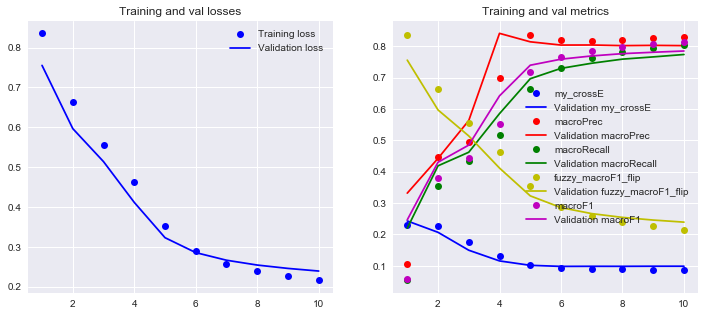

In [19]:
model2.plot()

### Comment
Again the validation data followed the test data during the 10 epochs. This time there is no notable plateau of the three metrics, precision/recall/F1, around 0.4. They comfortably rise together up to about 0.78 and stay there at practically the same value. Interestingly our other custom metric, the weighted categorical crossentropy (*my_crossE*) was warning us about overfitting starting already from 7th epoch.

In [20]:
# # the history may be loaded from file and played with later 
# hist = json.load(open(os.path.join("my_embeddings", "history_of_50dim_GlblAvg_CatCrossE_10epochs.p"), "r"))
# plot_history(hist)

---

### loss=*my_crossE*, class_weight=None

In [28]:
# dimension of the embedding space, output_dim
# custom loss_2

layers3 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model3 = BlackBox(layers=layers3, loss=my_crossE, class_weight=None, metrics=my_metrics)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_3 ( (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [29]:
model3.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 163s 326us/step - loss: 0.5752 - macroPrec: 0.0213 - macroF1: 1.7398e-04 - macroRecall: 8.7642e-05 - my_crossE: 0.5752 - fuzzy_macroF1_flip: 0.8647 - my_loss: 0.7199 - val_loss: 0.4901 - val_macroPrec: 0.3002 - val_macroF1: 0.0050 - val_macroRecall: 0.0026 - val_my_crossE: 0.4901 - val_fuzzy_macroF1_flip: 0.8189 - val_my_loss: 0.6545
Epoch 2/10
500000/500000 [==============================] - 162s 324us/step - loss: 0.3896 - macroPrec: 0.6241 - macroF1: 0.2262 - macroRecall: 0.1597 - my_crossE: 0.3896 - fuzzy_macroF1_flip: 0.7437 - my_loss: 0.5667 - val_loss: 0.3036 - val_macroPrec: 0.8569 - val_macroF1: 0.5185 - val_macroRecall: 0.3930 - val_my_crossE: 0.3036 - val_fuzzy_macroF1_flip: 0.6726 - val_my_loss: 0.4881
Epoch 3/10
500000/500000 [==============================] - 164s 328us/step - loss: 0.2489 - macroPrec: 0.8103 - macroF1: 0.6546 - macroRecall: 0.5717 - my_crossE: 

In [30]:
name = "50dim_GlblAvg_MyCrossE_{epochs}epochs"
model3.save_embedd(name)
model3.Ksave(name)
model3.save_hist(name)

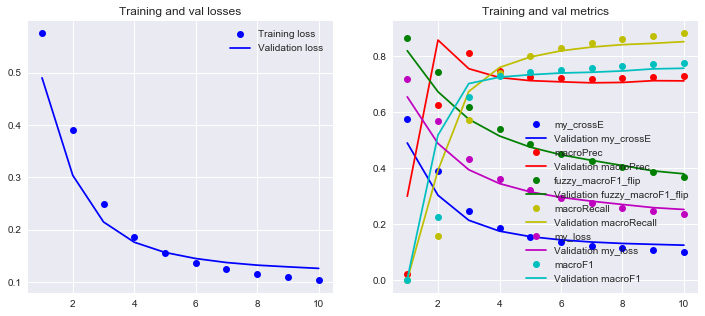

In [31]:
model3.plot()

### Comment
Very interestingly, this loss function (*my_crossE*) seems to prioritize recall over precision so that those are now in reversed order. The macro F1 raises monotonically up to 0.75% which is three points less than the previous loss function (*fuzzy_macroF1_flip*).

In [ ]:
# the history may be loaded from file and played with later 
hist = json.load(open(os.path.join("my_embeddings", "history_of_50dim_GlblAvg_CatCrossE_3epochs.p"), "r"))
plot_history(hist)

---

In [32]:
### loss=*my_lossE, class_weight=None

In [33]:
# dimension of the embedding space, output_dim
# custom loss_2

layers4 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model4 = BlackBox(layers=layers4, loss=my_loss, class_weight=None, metrics=my_metrics)
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_4 ( (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.fit()


### End